# Figure 1 

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from ParametricGraphModels.ADC_SBM import ADC_SBM, from_config
from config import Scenarios 
from graspy.simulations import sbm
from torch_geometric.datasets import Planetoid, Reddit
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE


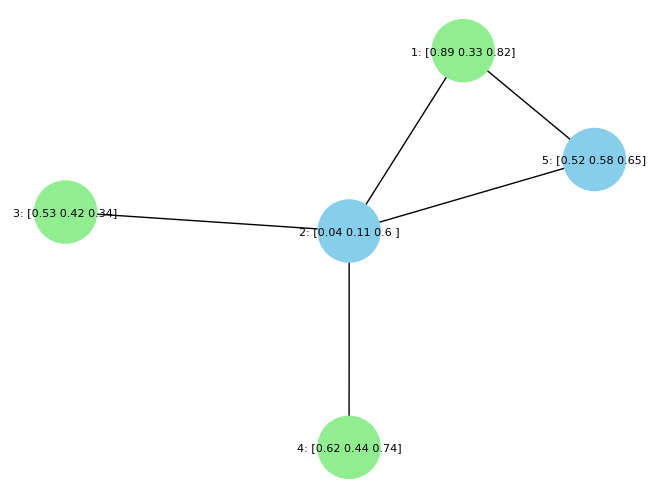

In [1]:
np.random.seed(6)
G = nx.erdos_renyi_graph(n=5, p=0.5, seed=12)

for node in G.nodes():
    G.nodes[node]['attr'] = np.round(np.random.rand(3),2) # Vector of 3 random attributes


labels = {node: f"{node+1}: {G.nodes[node]['attr']}" for node in G.nodes()}
colors = np.random.choice(['skyblue', 'lightgreen'], size=5)

pos = nx.spring_layout(G, seed=12)
nx.draw(G, pos, with_labels=False, node_color=colors, node_size=2000, font_size=10)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.show()


# Figure 2 

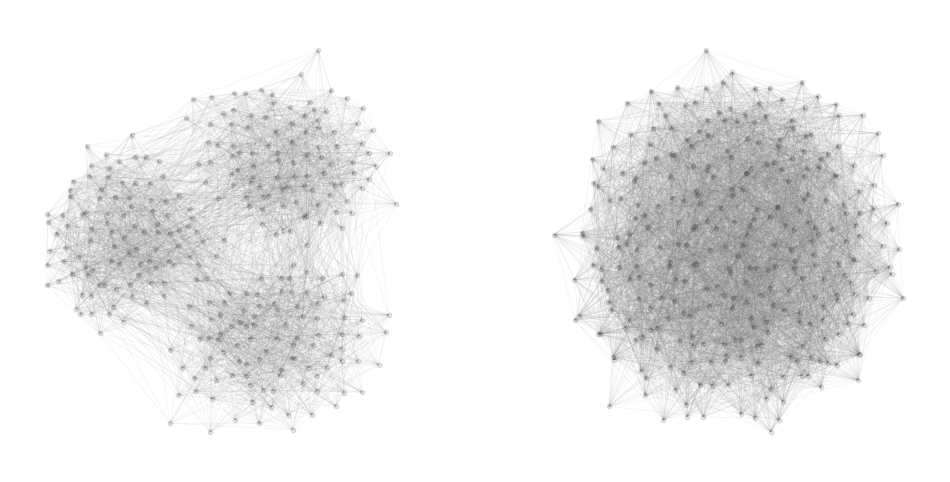

In [18]:
n = 3

d = 0.2
t1 = 0.03
t2 = 0.1

B1 = np.array(([[d,  t1, t1],
                [t1, d, t1],
                [t1, t1, d ]]))

B2 = np.array(([[d,  t2, t2],
                [t2, d, t2],
                [t2, t2, d]]))

sbm_graph1 = sbm([100, 100, 100], B1, loops=False)
sbm_graph2 = sbm([100, 100, 100], B2, loops=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


nx.draw(nx.from_numpy_array(sbm_graph1), 
        ax=axes[0], node_size=10, alpha=0.1, node_color="black", edge_color='gray', width=.5)
#axes[0].set_title(r'$\frac{𝜋_{w}}{𝜋_{b}} = \frac{0.2}{0.03}$')


nx.draw(nx.from_numpy_array(sbm_graph2), 
        ax=axes[1], node_size=10, alpha=0.1, node_color="black", edge_color='gray', width=.5)
#axes[1].set_title(r'$\frac{𝜋_{w}}{𝜋_{b}} =\frac{0.2}{0.1}$')

plt.show()

# Figure 3 

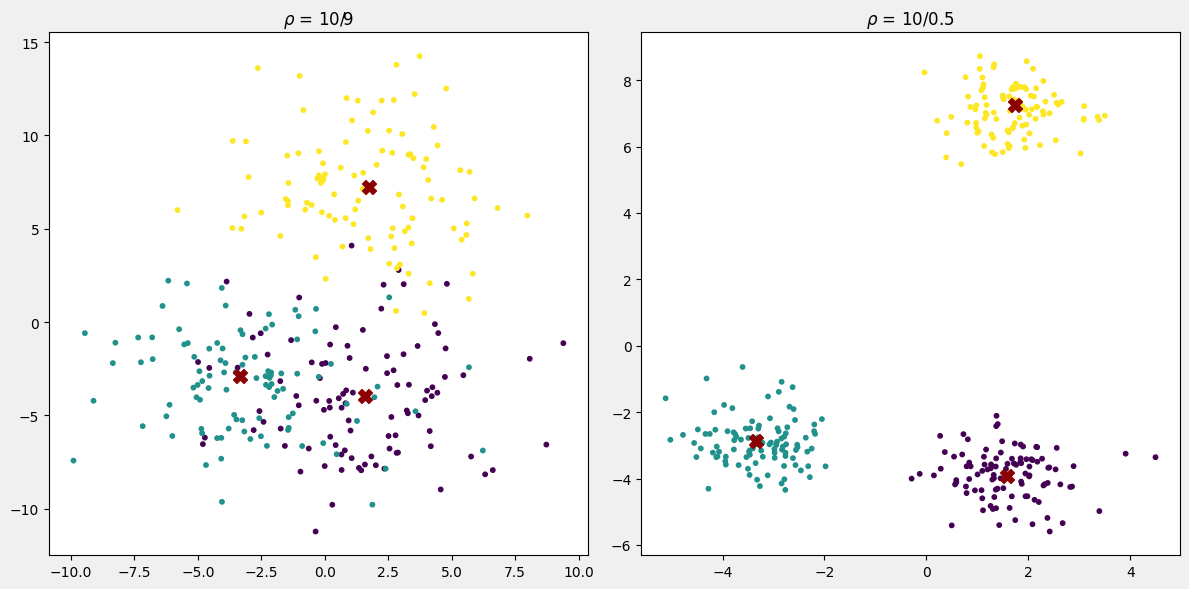

In [47]:
m_features = 2
k_clusters = 3 

def reduce_dim_x(x, rs=16):
    return TSNE(n_components=2, random_state=rs).fit_transform(x)

def getB(m: int, b_range: tuple, w_range: tuple, rs: int = None):
    if rs is not None:
        np.random.seed(rs)

    B = np.random.uniform(*b_range, size=(m, m))
    B = np.tril(B) + np.tril(B, -1).T
    np.fill_diagonal(B, np.random.uniform(*w_range, size=m))

    return B

np.random.seed(2)
centroids = np.random.multivariate_normal(np.zeros(m_features),
                                          getB(m_features, (0, 0), (10, 10)), 
                                          k_clusters)

def set_x(n_nodes, n_c: int, mu: list, sigma: list, w: any) -> np.array:

    component_labels = np.repeat(np.arange(len(w)), w)
    
    data = np.array([np.random.multivariate_normal(mu[label], sigma[label]) for label in component_labels])

    return data, component_labels

# Generating datasets
X1, C1 = set_x(300, k_clusters,
                mu=[tuple(point) for point in centroids],
                sigma=[getB(m_features, (0, 0), (.5, .5)) for _ in range(k_clusters)],
                w=[100] * k_clusters)

X2, C2 = set_x(300, k_clusters,
                mu=[tuple(point) for point in centroids],
                sigma=[getB(m_features, (0, 0), (9, 9)) for _ in range(k_clusters)],
                w=[100] * k_clusters)

#X1, X2 = reduce_dim_x(X1), reduce_dim_x(X2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.patch.set_facecolor('#f0f0f0') 

scatter1 = axes[0].scatter(X2[:, 0], X2[:, 1], c=C2, cmap='viridis', s=10)
axes[0].set_title(r"$\rho$ = 10/9")#'Ratio: 10/9')
scatter2 = axes[1].scatter(X1[:, 0], X1[:, 1], c=C1, cmap='viridis', s=10)
axes[1].set_title(r"$\rho$ = 10/0.5")

for ax in axes:
    ax.scatter(centroids[:, 0], centroids[:, 1], c='darkred', marker='X',s=100)

plt.tight_layout()
plt.show()


In [1]:
# Load datasets
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
citeseer_dataset = Planetoid(root='/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
pubmed_dataset = Planetoid(root='/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())
reddit_dataset = Reddit(root='/tmp/Reddit', transform=NormalizeFeatures())

In [2]:
def get_split_sizes(data):
    train_size = data[0].train_mask.sum().item()
    val_size = data[0].val_mask.sum().item()
    test_size = data[0].test_mask.sum().item()
    total_size = data[0].x.shape[0]
    x = np.array([train_size, test_size, val_size, total_size])
    return np.round(x[0:3]/x[3],3) * 100

cora_splits = get_split_sizes(cora_dataset)
citeseer_splits = get_split_sizes(citeseer_dataset)
pubmed_splits = get_split_sizes(pubmed_dataset)
reddit_splits = get_split_sizes(reddit_dataset)

print("Cora Splits:", cora_splits)
print("CiteSeer Splits:", citeseer_splits)
print("PubMed Splits:", pubmed_splits)
print("Reddit Splits:", reddit_splits)


Cora Splits: [ 5.2 36.9 18.5]
CiteSeer Splits: [ 3.6 30.1 15. ]
PubMed Splits: [0.3 5.1 2.5]
Reddit Splits: [65.9 23.9 10.2]


In [48]:
from torch_geometric.datasets import PPI, Planetoid

# Load the PPI dataset
ppi_dataset = PPI(root='data/PPI')
ppi_data = ppi_dataset[0]  # accessing the first graph in the dataset

ppi_num_features = ppi_data.num_features

print(f"PPI Dataset: {ppi_num_features} features")


Extracting data\PPI\ppi.zip
Processing...


PPI Dataset: 50 features


Done!
